### Example:
- data cleaning
- feature creation
- feature engineering
- Sample data virtualization

In [1]:
# Imports
import pandas as pd
import numpy as np
from datetime import datetime

# Holiday Data Preprocessing
- Extracts the first month and day from holiday dates.
- Categorizes holiday types (e.g., Thai National, Festival, International).
- Classifies seasons into High, Shoulder, and Low seasons.
- Saves the cleaned data as processed_holidays.csv for further analysis

In [2]:
# Read the data
df = pd.read_csv('holidays.csv')

def process_month(month_str):
    """Extract the first month from potentially multiple months."""
    # Split on common separators and take first month
    month_str = str(month_str).split('/')[0].split('-')[0].split()[0].strip()
    
    # Convert month name to number
    month_map = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4,
        'May': 5, 'June': 6, 'July': 7, 'August': 8,
        'September': 9, 'October': 10, 'November': 11, 'December': 12
    }
    return month_map.get(month_str, np.nan)

def process_day(day_str):
    """Extract the first day from potentially multiple days or ranges."""
    if pd.isna(day_str) or day_str == 'Varies' or 'Full Moon' in str(day_str):
        return np.nan
    
    # Split on common separators and take first day
    try:
        day = str(day_str).split('-')[0].split('/')[0].split()[0].strip()
        return int(day)
    except (ValueError, AttributeError):
        return np.nan

def process_holiday_type(type_str):
    """Categorize holiday types into main categories."""
    type_str = str(type_str).lower()
    if 'thai national' in type_str:
        return 'Thai National'
    elif 'thai festival' in type_str or 'thai buddhist' in type_str:
        return 'Thai Festival'
    elif 'international' in type_str or 'regional' in type_str:
        return 'International'
    elif 'general' in type_str:
        return 'General Season'
    else:
        return 'Other'

def process_season(season_str):
    """Categorize seasons into main categories."""
    season_str = str(season_str).lower()
    if 'high season' in season_str or 'peak' in season_str:
        return 'High Season'
    elif 'shoulder season' in season_str:
        return 'Shoulder Season'
    elif 'low season' in season_str:
        return 'Low Season'
    else:
        return 'Unknown'

# Create processed DataFrame
processed_df = pd.DataFrame()
processed_df['Holiday/Festival'] = df['Holiday/Festival']

# Process month and day
processed_df['Processed_Month'] = df['Month'].apply(process_month)
processed_df['Processed_Day'] = df['Day'].apply(process_day)

# Process holiday type and season
processed_df['Holiday_Type'] = df['Type'].apply(process_holiday_type)
processed_df['Season_Flag'] = df['Season'].apply(process_season)

# Save the processed data
processed_df.to_csv('processed_holidays.csv', index=False)

# Tourism Data Preprocessing
- Reshapes the dataset by converting months from columns to rows.
- Cleans numerical data by removing commas and converting values to numeric format.
- Filters for 2024 only, ensuring the data aligns with the study’s focus.
- Aggregates total tourist numbers across all regions for each month.
- Saves the cleaned data as processed_tourism.csv for further analysis.

In [3]:
# Read the dataset
df = pd.read_csv('thailand_tourism.csv')

# Clean the column names (strip any extra spaces)
df.columns = df.columns.str.strip()

# Melt the DataFrame to reshape the months from columns to rows
df_melted = pd.melt(df, id_vars=['Months'], var_name='Month', value_name='Tourists')

# Remove any extra spaces in the 'Months' column
df_melted['Months'] = df_melted['Months'].str.strip()

# Clean the 'Tourists' column by removing commas and converting to numeric
df_melted['Tourists'] = df_melted['Tourists'].replace({',': ''}, regex=True).astype(float)

# Create a month mapping to extract month and year
month_map = {
    'Jan 2024': 1, 'Feb 2024': 2, 'Mar 2024': 3, 'Apr 2024': 4, 'May 2024': 5, 'Jun 2024': 6,
    'Jul 2024': 7, 'Aug 2024': 8, 'Sep 2024': 9, 'Oct 2024': 10, 'Nov 2024': 11, 'Dec 2024': 12
}

# Map months to numeric values for 2024 only
df_melted['Month'] = df_melted['Month'].map(month_map)

# Filter the data to keep only the months of 2024
df_melted = df_melted[df_melted['Month'].notna()]

# Group by 'Month' and sum the 'Tourists' values across all regions
df_total_tourists = df_melted.groupby('Month')['Tourists'].sum().reset_index()

# Ensure 'Month' is an integer type (no decimals)
df_total_tourists['Month'] = df_total_tourists['Month'].astype(int)

# Save the processed data to a new CSV file
df_total_tourists.to_csv('processed_tourism.csv', index=False)

# Airbnb Listings Data Preprocessing
- Removes missing values in last_review and price.
- Extracts the month from last_review for time-based analysis.
- Cleans the price column by converting it to numeric format.
- Encodes room types as dummy variables for modeling.
- Saves the processed data as processed_listings.csv for further analysis

In [4]:
# Read the listings data
df = pd.read_csv('listings.csv')

def process_airbnb_data(df):
    """Process Airbnb listings data."""
    # Create a copy to avoid modifying original data
    processed_df = df.copy()

    # Drop rows where 'last_review' is missing
    processed_df = processed_df.dropna(subset=['last_review'])
    
    # Drop rows where 'price' is missing
    processed_df = processed_df.dropna(subset=['price'])
    
    # Convert last_review to datetime and extract month
    processed_df['last_review'] = pd.to_datetime(processed_df['last_review'])
    processed_df['last_review_month'] = processed_df['last_review'].dt.month
    
    # Clean price column (convert to float)
    processed_df['price'] = pd.to_numeric(processed_df['price'], errors='coerce')
    
    # Create dummy variables for room_type
    room_type_dummies = pd.get_dummies(processed_df['room_type'], prefix='room_type')
    
    # Combine relevant columns
    final_df = pd.concat([
        processed_df[['last_review_month', 'price']],
        room_type_dummies
    ], axis=1)
    
    return final_df, processed_df

# Process the data
processed_df, full_processed_df = process_airbnb_data(df)

room_type_cols = [col for col in processed_df.columns if col.startswith('room_type_')]
room_type_distribution = processed_df[room_type_cols].sum().sort_values(ascending=False)

# Save processed data
processed_df.to_csv('processed_listings.csv', index=False)


# Merging Datasets for Model Training
- Merges Airbnb listings with tourism data using last_review_month. (We assumed that the last review month is the month the Airbnb was booked)
- Adds holiday and season information to account for demand fluctuations.
- Handles missing values by filling in reasonable defaults.
- Reorders columns for clarity and prepares the final dataset for model training.
- Saves the merged dataset as merged_tourism_data.csv

In [5]:
# Read the processed datasets
listings_df = pd.read_csv('processed_listings.csv')
tourism_df = pd.read_csv('processed_tourism.csv')
holidays_df = pd.read_csv('processed_holidays.csv')

def merge_datasets(listings_df, tourism_df, holidays_df):
    """
    Merge the three datasets based on month and handle missing values.
    """
    # First merge: Listings with Tourism
    merged_df = pd.merge(
        listings_df,
        tourism_df,
        left_on='last_review_month',
        right_on='Month',
        how='left'
    )
    
    # Drop duplicate Month column
    merged_df = merged_df.drop('Month', axis=1)
    
    # Second merge: Add Holiday data
    final_df = pd.merge(
        merged_df,
        holidays_df,
        left_on='last_review_month',
        right_on='Processed_Month',
        how='left'
    )
    
    # Drop duplicate month column and unnecessary columns
    columns_to_drop = ['Processed_Month', 'Processed_Day', 'Holiday_Type']
    final_df = final_df.drop(columns_to_drop, axis=1, errors='ignore')
    
    # Handle missing values
    final_df['Holiday/Festival'] = final_df['Holiday/Festival'].fillna('No Holiday')
    final_df['Season_Flag'] = final_df['Season_Flag'].fillna('Regular Season')
    final_df['Tourists'] = final_df['Tourists'].fillna(final_df['Tourists'].mean())
    
    # Reorder columns for clarity
    column_order = [
        'last_review_month',
        'price',
        'Tourists',
        'Holiday/Festival',
        'Season_Flag'
    ]
    
    # Add room type columns to the order
    room_type_cols = [col for col in final_df.columns if col.startswith('room_type_')]
    column_order.extend(room_type_cols)
    
    # Select and order columns
    final_df = final_df[column_order]
    
    return final_df

# Merge the datasets
final_df = merge_datasets(listings_df, tourism_df, holidays_df)

# Save the merged dataset
final_df.to_csv('merged_tourism_data.csv', index=False)

# Data Visualization Samples
1. Tourist Volume by Month:

- A bar chart visualizes the total number of tourists by month from the processed tourism data.
- The chart helps identify high-tourist months.

2. Average Airbnb Price by Month:

- A line chart displays the average Airbnb price for each month based on the last review date.
- This helps track how Airbnb prices fluctuate over the months.

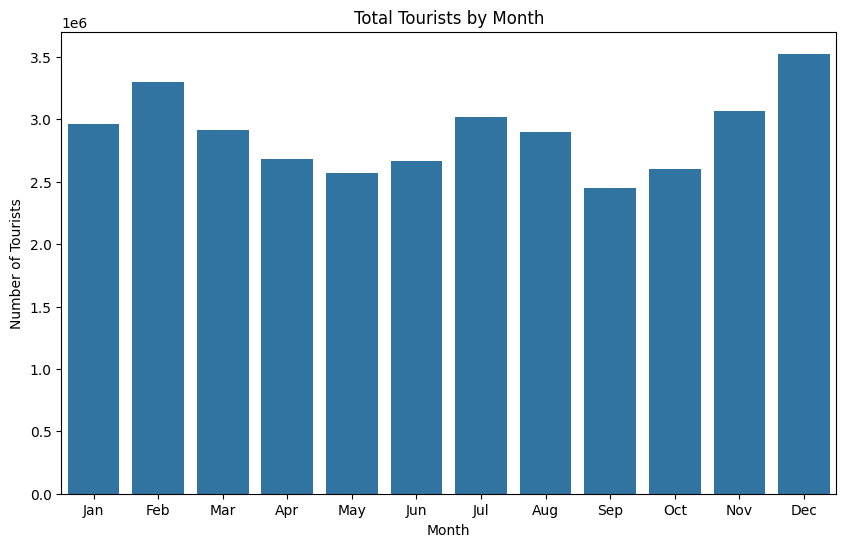

NameError: name 'airbnb_df' is not defined

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the processed tourism data
tourism_df = pd.read_csv('processed_tourism.csv')

# Create a bar chart for tourist numbers by month
plt.figure(figsize=(10, 6))
sns.barplot(data=tourism_df, x='Month', y='Tourists')
plt.title('Total Tourists by Month')
plt.xlabel('Month')
plt.ylabel('Number of Tourists')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

# Create a line chart for average price by last review month
avg_price = airbnb_df.groupby('last_review_month')['price'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_price, x='last_review_month', y='price', marker='o')
plt.title('Average Airbnb Price by Last Review Month')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()